This will be my GAN model used to create semi-realistic face images using the celeb A dataset.  First I will import all of the relevant libraries 

In [8]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import datasets

Next I will create a seed for this torch model in order to have reproducibility for the model.  We will also use deterministic algorithms to true as well to again ensure reproducibility of the results. 

In [9]:
manualSeed = 999 # Random choice for reproducing same results
print("Random Seed: ", manualSeed) # Print out the seed 
random.seed(manualSeed) # Set the seed 
torch.manual_seed(manualSeed) # Set the seed in pytorch
torch.use_deterministic_algorithms(True) # Turn on the deterministic algorithms 

Random Seed:  999


Next we will setup the hyperparameters for the model.  These include the dataset directory path, the number of workers for the dataloader, the batch size for training, the size of the images.  We also set the number of input channels for the model (3 for colour images), the latent vector size for the generator input, the feature map sizes for the generator and the discriminator.  The number of epochs or training cycles, the learning rate of the model, the Beta1 paramentere for the Adam optimiser and the number of available GPU's 

In [10]:
dataroot = './CelebA' # Root directory for dataset
workers = 2 # Number of workers for dataloader
batch_size = 128 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this. #   size using a transformer.
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 5 # Number of training epochs, arbitrary choice mainly for time 
lr = 0.0002 # Learning rate for optimizers, we want to avoid overshooting 
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

Next we will want to load in our data for the celebA dataset.  I will have it downloaded locally in my the same directoty as my model. in the CelebA directory it has the following structure. 

./CelebA
    -> ./img_align_celeba
    -> identity_CelebA.txt
    -> list_attr_celeba.txt
    -> list_bbox_celeba.txt
    -> list_eval_partition.txt
    -> list_landmarks_align.txt
    -> list_landmarks_celeba.txt

Then we load this data into an ImageFolder dset, apply our transforms and then load the new dataset into the dataloader we will use for the model 

In [11]:
# Use an image folder to store the local data and load it in 
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# The transform to apply to the data for better overall results
transform=transforms.Compose([transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

Now we will setup the gpu, as the device to use for the model, using the parrelism of the GPU will be vital for this model due to how much processing that we need to do. 

In [12]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")# Decide which device we want to run on

Now lets print out some pretty images to look at 

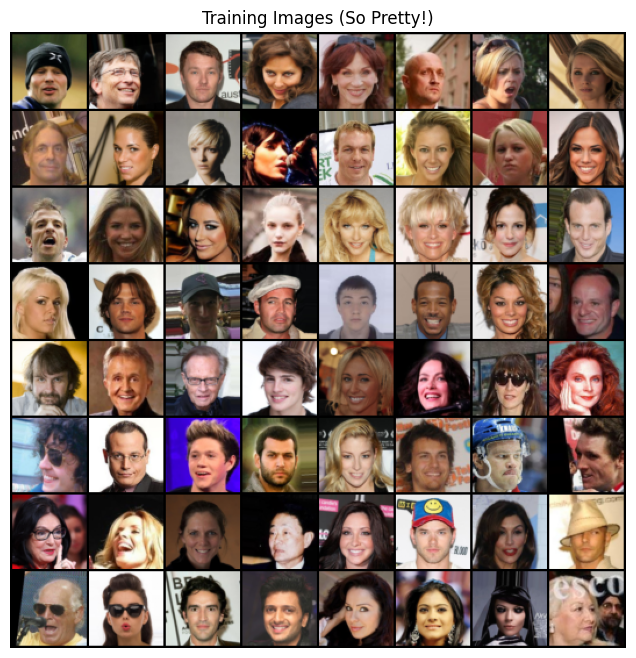

In [13]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images (So Pretty!)")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Next we wanna set the weights for the models to use that is both the netG and netD (Generator and Discriminator Neural Networks).  

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Now we get to the fun part its time to create the models for the generator and the discriminator neural networks.  We will create the generator model first. 

This Generator network takes a random noise vector 'Z' as input and transforms it through a series of transposed convolutional layers with batch normalization and ReLU activations to produce a synthetic image that aims to resemble real data samples. The architecture gradually increases the spatial resolution while adjusting the number of features, ultimately generating an image of size 3 x 64 x 64. 

Now lets break down each of the functions used in the layers of this model:

ConvTranspose2d -> This is a transposed convolution layer, it increases spatial resolution of the image data aka unsampling.

BatchNorm2d -> This applies a batch normalisation to the output of the convolutional layer, its used to stabilsie the training by normalising the inputs

ReLU -> Thus is an activation function that takes the output and introduces non-linearity. 

Tanh -> This is an activation function that takes the input and compressess it between -1 and 1 which is a sutiable range for generating pixel values. 

In [15]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

Next we will create the generator model, applying the inital weights that we wanted with mean 0 and stdev of 0.02.  So that the weights start with random values.  In the hopes to make the model slightly faster compared to uninitialised weights. 

In [16]:
netG = Generator(ngpu).to(device) # Create the generator
netG.apply(weights_init) # Apply the ``weights_init`` function to randomly initialize all weights
print(netG) # Print the model

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Now lets to the same thing with the Discriminator model, It will obviouslty be using different layers for it's model so we will do through them below:

Conv2d -> 
BatchNorm2d ->
LeakyRelu ->
Sigmoid -> 


In [ ]:

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now lets do the same thing and create the discriminator model and set its weights.  Then we will print it out to the screen 

In [ ]:
netD = Discriminator(ngpu).to(device) # Create the Discriminator
netD.apply(weights_init) # Apply the ``weights_init`` function to randomly initialize all weights
print(netD) # Print the model